## CatsDogsPanda Image Classification using MiniVGGNet with Batch Normalization

**Objective:** Classify the CatsDogsPanda images using MiniVGGNet
  * Use BatchNormalization while defining the miniVGGNet
  * Use SGD optimization parameters : decay, momentum and nestrov

## About MiniVGGNet

* The 3x3 kernels/filter are being used through out the architecture.
* The VGG16 & VGG19 architecture use the filters to increasing depth 16 and 19 layers respectively.
* Stacks multiple Conv and Relu layers before the pool layers.

## Define MiniVGGNet

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

Using Theano backend.


In [2]:
#?Conv2D
#?MaxPooling2D
?BatchNormalization

In [3]:
#define miniVGGNet

# input size: 3x3 filters, num of filters 32
# then : 3x3 filters, num of filters 64
#
# 2 sets of Conv -> Relu -> Conv -> Relu -> Pool 
# perfrom Batch Normalization after the activation function
# followed by, FC -> Relu -> FC -> Softmax
def miniVGGNet(width, height, depth, num_classes):
    
    model = Sequential()
    
    inputShape = (height, width, depth)
    pad = 'same'
    
    # first set
    model.add(Conv2D(32, (3,3), input_shape=inputShape, padding=pad))
    model.add(Activation('relu'))
    # channels last, so axis=-1, which is by default
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding=pad))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))
    
    # second set
    model.add(Conv2D(64, (3,3), padding=pad))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3,3), padding=pad))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))
    
    #FC
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    #FC + softmax
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.summary()
    return model

## Read all Images

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib
import glob
import random
import os

In [5]:
print('numpy: ', np.__version__)
print('opencv: ', cv2.__version__)

numpy:  1.14.2
opencv:  3.4.4


In [6]:
ImageDir = '../datasets/animals'

# recursively go over the datset folder and get the file names.
ImageList = list(pathlib.Path(ImageDir).rglob('*.jpg'))
print(len(ImageList))

3000


In [7]:
## load all the images
## resize them to one size
def preprocess_image(img, width, height, interpolation=cv2.INTER_AREA):
    return( cv2.resize(img, (width, height), interpolation))

In [8]:
# load all images.
def load_all_images(imageList, verbose=-1):
    data = []
    labels = []

    # go over each image - read them and extract class label from the path
    for (i, imagepath) in enumerate(imageList):
        filename = imagepath.as_posix()
        img = cv2.imread(filename)
        label = filename.split(os.path.sep)[-2]
        img = preprocess_image(img, 32, 32)

        data.append(img)
        labels.append(label)

        if ( verbose > 0 and i > 0 and (i+1) % verbose == 0):
            print('Info: Processed {} / {}'.format(i+1, len(imageList)))


    return(np.array(data), np.array(labels))

In [9]:
##
print('Load All Images...')
(data, labels) = load_all_images(ImageList, verbose=250)

Load All Images...
Info: Processed 250 / 3000
Info: Processed 500 / 3000
Info: Processed 750 / 3000
Info: Processed 1000 / 3000
Info: Processed 1250 / 3000
Info: Processed 1500 / 3000
Info: Processed 1750 / 3000
Info: Processed 2000 / 3000
Info: Processed 2250 / 3000
Info: Processed 2500 / 3000
Info: Processed 2750 / 3000
Info: Processed 3000 / 3000


In [10]:
print(data.shape)

(3000, 32, 32, 3)


### Normalize the data input

In [11]:
data = data.astype("float") / 255.0

### Split the train and test dataset

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=123)

In [14]:
## convert the labels to vector
from sklearn.preprocessing import LabelBinarizer

trainY = LabelBinarizer().fit_transform(trainY)
testY  = LabelBinarizer().fit_transform(testY)

In [15]:
print(trainY[0:3])
print(testY[0:3])

[[1 0 0]
 [0 1 0]
 [1 0 0]]
[[0 1 0]
 [0 1 0]
 [1 0 0]]


## Build the Model

In [16]:
from keras.optimizers import SGD

In [17]:
?SGD

In [18]:
num_epochs = 25
sgd = SGD(lr=0.005, decay=0.005 / num_epochs, momentum=0.9, nesterov=True)
model = miniVGGNet(width=32, height=32, depth=3, num_classes=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

## Train and Evaluate

In [20]:
?model.fit

In [21]:
# train the network
print("Train the network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=num_epochs, verbose=1)

Train the network...
Train on 2250 samples, validate on 750 samples
Epoch 1/25
2250/2250 [==============================] - 35s 15ms/step - loss: 1.0468 - acc: 0.5973 - val_loss: 1.4725 - val_acc: 0.3720
Epoch 2/25
2250/2250 [==============================] - 34s 15ms/step - loss: 0.6407 - acc: 0.7058 - val_loss: 1.4509 - val_acc: 0.3707
Epoch 3/25
2250/2250 [==============================] - 34s 15ms/step - loss: 0.4854 - acc: 0.7858 - val_loss: 1.3642 - val_acc: 0.3973
Epoch 4/25
2250/2250 [==============================] - 34s 15ms/step - loss: 0.3709 - acc: 0.8378 - val_loss: 1.2833 - val_acc: 0.4653
Epoch 5/25
2250/2250 [==============================] - 34s 15ms/step - loss: 0.3026 - acc: 0.8791 - val_loss: 0.9356 - val_acc: 0.6293
Epoch 6/25
2250/2250 [==============================] - 34s 15ms/step - loss: 0.1732 - acc: 0.9404 - val_loss: 0.9504 - val_acc: 0.6627
Epoch 7/25
2250/2250 [==============================] - 34s 15ms/step - loss: 0.1252 - acc: 0.9582 - val_loss: 1.021

In [22]:
#H.history

In [23]:
from sklearn.metrics import confusion_matrix, classification_report #metric

In [24]:
pred = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), pred.argmax(axis=1), target_names=["cat", "dog", "panda"]))

              precision    recall  f1-score   support

         cat       0.63      0.71      0.67       252
         dog       0.64      0.57      0.60       240
       panda       0.89      0.86      0.88       258

   micro avg       0.72      0.72      0.72       750
   macro avg       0.72      0.72      0.72       750
weighted avg       0.72      0.72      0.72       750



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testY.argmax(axis=1), pred.argmax(axis=1)))

[[179  63  10]
 [ 85 137  18]
 [ 21  14 223]]


In [26]:
from sklearn.metrics import accuracy_score
print(accuracy_score(testY.argmax(axis=1), pred.argmax(axis=1)))

0.7186666666666667


## Plot Loss and Accuracy

In [27]:
import matplotlib.pyplot as plt

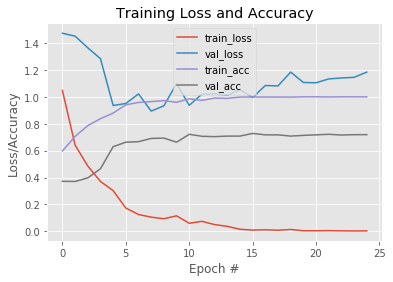

In [28]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Save the model

In [30]:
# mini VGG net with batch normalization
model.save('CatsDogsPanda_miniVGGNet_bn_weights.hdf5')